# Calculating geostrophic flow & Look at vertical velocities

Motivation: tell the difference between (a) and (b) for their contribution to the freshwater change.

<img src="../../_figures/FWC_sketch.png" width=900 align="center"/>
<center>----------------------</center> 
<center>Sketches of FWC increases due to (a) Redistribution of freshwater component, (b) Ekman transport and (c) Sea-ice melt/formation.</center> 

<center>(b) and (c) were inspired by Proshutinsky et al.(2010).</center> 

*Proshutinsky et al. (2010) Freshwater transformations in the Beaufort Gyre and model intercomparison results. AOMIP Workshop #14.*

In [6]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [15]:
import glob
import cartopy
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [8]:
sb.set_style('white')

In [25]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def interp_np(xin, yin, zin, xout, yout):
    zout = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='linear')
    zfill = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='nearest')
    zout[np.isnan(zout)] = zfill[np.isnan(zout)]
    zout[yout>89.99] = np.nan
    return zout

In [21]:
ocean_x = np.linspace(-180, 180, 140)
ocean_y = np.linspace(20, 90, 140)
ocean_lon, ocean_lat = np.meshgrid(ocean_x, ocean_y)

In [50]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]
#
dep_name = '/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc'
dep_obj = nc.Dataset(dep_name)
deptht = dep_obj.variables['nav_lev'][:]
#
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan
ssh_mean = ssh[1, :, :]
#
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current_d23.mat')
vozocrtx0 = MAT['vozocrtx'][:]
vomecrty0 = MAT['vomecrty'][:]
u_mean = vozocrtx0[1, :, :]
v_mean = vomecrty0[1, :, :]

In [11]:
omega = 7.292*1e-5; # rotational velocity
g = 9.8; # m/s^2 % gravity
f = 2*omega*np.sin(ocean_lat*np.pi/180.0);

# Geotrophic flow by SSH

* **ANHA4 Grid SSH** ---(interp)---> **xygrid SSH** ---(finite diff)---> **xygrid geostrophic flow** ---(interp)---> **ANHA4 Grid geo. flow**

Equations
$$
u_g = -\frac{g}{f}\frac{\Delta H}{\Delta y}\\
v_g = \frac{g}{f}\frac{\Delta H}{\Delta x}
$$

Then
$$
\Delta x = R\Delta lon \cdot cos(lat) \\
\Delta y = R\Delta lat
$$


In [53]:
ssh_regrid = interp_np(nav_lon, nav_lat, ssh_mean, ocean_lon, ocean_lat)
ug, vg = Ats.geo_wind(ocean_lon, ocean_lat, ssh_regrid)

In [54]:
ug_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, ug, nav_lon, nav_lat, method='linear')
vg_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, vg, nav_lon, nav_lat, method='linear')

In [55]:
u_regrid = interp_np(nav_lon, nav_lat, u_mean, ocean_lon, ocean_lat)
v_regrid = interp_np(nav_lon, nav_lat, v_mean, ocean_lon, ocean_lat)
u_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, u_regrid, nav_lon, nav_lat, method='linear')
v_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, v_regrid, nav_lon, nav_lat, method='linear')

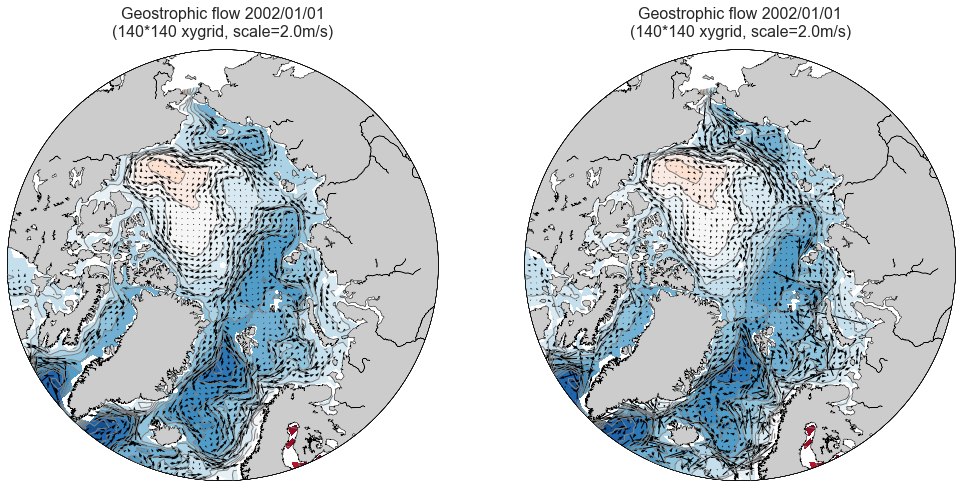

In [57]:
fig = plt.figure(figsize=(17, 17))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x0, y0 = proj(ocean_lon, ocean_lat)
uproj, vproj = proj.rotate_vector(ug, vg, ocean_lon, ocean_lat, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x, ocean_y, 75, 75, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x, ocean_y, 75, 75, returnxy=True)

proj.contourf(x0, y0, ssh_regrid, 25, cmap=plt.cm.RdBu_r)
proj.contour (x0, y0, ssh_regrid, 25, linestyles='-', colors='gray', linewidths=1.0)
Q = proj.quiver(x, y, uproj_rec, vproj_rec, scale=2.0)
ax1.set_title('Geostrophic flow 2002/01/01\n(140*140 xygrid, scale=2.0m/s)', fontsize=16, y=1.02)

proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x0, y0 = proj(ocean_lon, ocean_lat)

uproj, vproj = proj.rotate_vector(u_regrid, v_regrid, ocean_lon, ocean_lat, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x, ocean_y, 75, 75, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x, ocean_y, 75, 75, returnxy=True)
proj.contourf(x0, y0, ssh_regrid, 25, cmap=plt.cm.RdBu_r)
proj.contour(x0, y0, ssh_regrid, 25, linestyles='-', colors='gray', linewidths=1.0)
Q = proj.quiver(x, y, uproj_rec, vproj_rec, scale=2.0)
ax2.set_title('Geostrophic flow 2002/01/01\n(140*140 xygrid, scale=2.0m/s)', fontsize=16, y=1.02)

# Geostrophic velocity from 0 - 130m

$$
\mathrm{PGF} = \mathrm{Coriolis}\\
P = \rho g(\mathrm{deptht} + \mathrm{ssh})
$$

The density ($\rho$) can be calculated by temperature and salinity through *Millero et. al (1980).*

*Millero, F. J., et al. (1980) A new high pressure equation of state for seawater. Deep Sea Res. Part A. Oceanographic Research Papers **27**(3), 255-264pp.*

I can (1) choose 65m (in the middle of 0-130m) to represent the layer or (2) Calculate the average from 0 to 130m

------------------------
 
Found: ssh and $\rho$ both have spatial variability, but the impact of ssh is larger than $\rho$. The geostrophic flow still follows the gradient of ssh in this method.

In [13]:
import seawater as sw

In [14]:
SName = sorted(glob.glob('../../_data/MAT files/vosaline_by_month/vosaline*mat'))
vosaline0 = scipy.io.loadmat(SName[0])['vosaline'][0, :, :]
vosaline19 = scipy.io.loadmat(SName[0])['vosaline'][19, :, :]

t_obj = nc.Dataset('../../_data/MAT files/votemper_by_layer/votemper0_monmean.nc')
votemper0 = t_obj.variables['votemper'][0, :, :]
t_obj = nc.Dataset('../../_data/MAT files/votemper_by_layer/votemper19_monmean.nc')
votemper19 = t_obj.variables['votemper'][19, :, :]
votemper19[votemper19>50]=np.nan
t19 = sw.library.T90conv(votemper19)
rho19 = sw.dens0(vosaline19, t19)
#p19 = rho*deptht[19]*9.8

In [15]:
P = rho19*9.8*(ssh_mean+65)

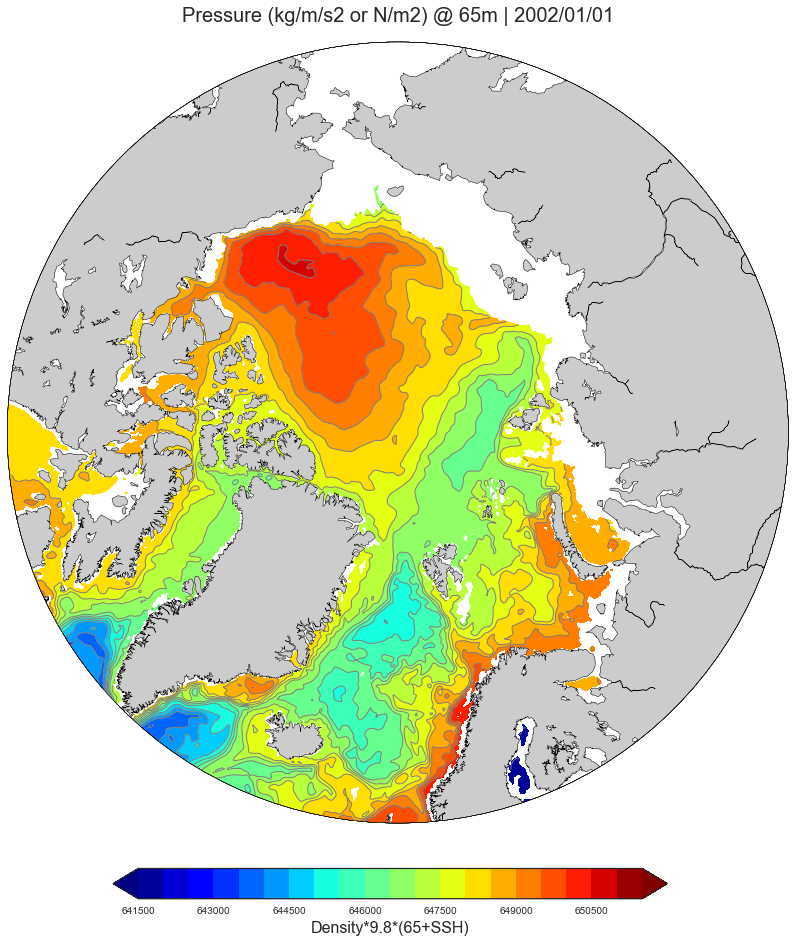

In [16]:
fig = plt.figure(figsize=(14, 14))
ax = plt.gca()
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, P, 20, cmap=plt.cm.jet, extend='both')
proj.contour(x, y, P, 20, linestyles='-', colors='gray', linewidths=1.0)

ax.set_title('Pressure (kg/m/s2 or N/m2) @ 65m | 2002/01/01', fontsize=20, y=1.02)

cax  = fig.add_axes([0.23, 0.05, 0.55, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Density*9.8*(65+SSH)', fontsize=16)
CBar.ax.tick_params(axis='x', length=0, direction='in')
#CBar.set_ticks(lev_rho)

In [17]:
rho_regrid = interp_np(nav_lon, nav_lat, rho19, ocean_lon, ocean_lat)
P_regrid = interp_np(nav_lon, nav_lat, P, ocean_lon, ocean_lat)
Px, Py = Ats.grad_atmos(ocean_lon, ocean_lat, P_regrid)
ug19 = -1/(f*rho_regrid)*Py
vg19 = 1/(f*rho_regrid)*Px

In [18]:
ug_ANHA4[np.isnan(votemper19)] = np.nan
vg_ANHA4[np.isnan(votemper19)] = np.nan

/home/yingkai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


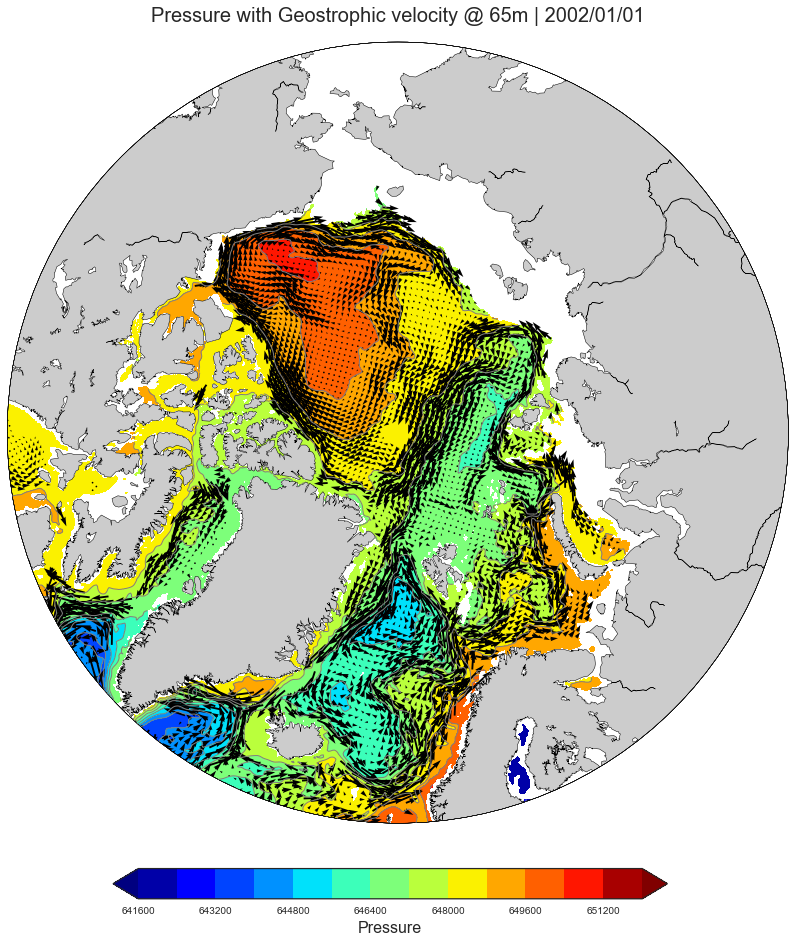

In [19]:
n = 4.0
fig = plt.figure(figsize=(14, 14))
ax = plt.gca()
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
#x, y = proj(nav_lon, nav_lat)
#x2, y2 = proj(ocean_lon, ocean_lat)
uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)

CS = proj.contourf(x, y, P, 15, cmap=plt.cm.jet, extend='both')
proj.contour(x, y, P, 15, linestyles='-', colors='gray', linewidths=1.0)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], uproj[::n, ::n], vproj[::n, ::n], scale=2.5)
ax.set_title('Pressure with Geostrophic velocity @ 65m | 2002/01/01', fontsize=20, y=1.02)

cax  = fig.add_axes([0.23, 0.05, 0.55, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Pressure', fontsize=16)
CBar.ax.tick_params(axis='x', length=0, direction='in')
#CBar.set_ticks(lev_rho)

In [230]:
#taux_obj=nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sozotaux_monmean.nc')
#taux = taux_obj.variables['sozotaux'][:]
#tauy_obj=nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sometauy_monmean.nc')
#tauy = tauy_obj.variables['sometauy'][:]

In [231]:
#taux[np.abs(taux)>100] = np.nan
#tauy[np.abs(tauy)>100] = np.nan
#taux_regrid = interp_np(nav_lon, nav_lat, taux[5, :, :], ocean_lon, ocean_lat)
#tauy_regrid = interp_np(nav_lon, nav_lat, tauy[5, :, :], ocean_lon, ocean_lat)
#curlz_tau = Ats.curlz_atmos(ocean_lon, ocean_lat, taux_regrid, tauy_regrid)

In [232]:
#curlz_tau_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, curlz_tau, nav_lon, nav_lat, method='linear')

In [233]:
#lev_adv = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])*0.2

In [234]:
#n=5
#fig = plt.figure(figsize=(14, 14))
#ax = fig.gca()
#
#proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj.fillcontinents(color='0.8', lake_color=None)
#proj.drawcoastlines(linewidth=0.5, color='k')
#x, y = proj(nav_lon, nav_lat)
##uproj, vproj, x, y = proj.rotate_vector(taux_regrid[:, :], tauy_regrid[:, :], ocean_lon, ocean_lat, returnxy=True)
#proj.contourf(x, y, curlz_tau_ANHA4*1e6, lev_adv/4.0, cmap=plt.cm.RdBu_r)
#Q = proj.quiver(x[::n, ::n], y[::n, ::n], taux[5, ::n, ::n], tauy[5, ::n, ::n], scale=2)
#ax1.set_title('Geostrophic flow 2002/01/01\n(140*140 xygrid, scale=2.0m/s)', fontsize=16, y=1.02)

In [235]:
#n=10
#fig = plt.figure(figsize=(14, 14))
#ax = fig.gca()
#
#proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj.fillcontinents(color='0.8', lake_color=None)
#proj.drawcoastlines(linewidth=0.5, color='k')
#
#uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)
#speed = np.sqrt((ug_ANHA4*Ba[1, :, :])**2+(vg_ANHA4*Ba[1, :, :])**2)
#proj.contourf(x, y, speed, 20, cmap=plt.cm.gist_ncar_r)
#Q = proj.quiver(x[::n, ::n], y[::n, ::n], uproj[::n, ::n], vproj[::n, ::n], scale=5)
#ax1.set_title('Geostrophic flow 2002/01/01\n(140*140 xygrid, scale=2.0m/s)', fontsize=16, y=1.02)

In [95]:
#fig = plt.figure(figsize=(12, 12))
#ax = fig.gca()
#n = 4
#proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj.fillcontinents(color='0.8', lake_color=None)
#proj.drawcoastlines(linewidth=0.5, color='k')

#uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)
#CS = proj.contourf(x, y, ssh_mean, 25, cmap=plt.cm.RdBu_r)
#proj.contour(x, y, ssh_mean, 25, linestyles='-', colors='gray', linewidths=1.0)
#Q = proj.quiver(x[::n, ::n], y[::n, ::n], u_ANHA4[::n, ::n]-uproj[::n, ::n], v_ANHA4[::n, ::n]-vproj[::n, ::n], scale=2.0)
#ax.set_title('Original u/v minus geostrophic u/v (scale=1.0m/s)', fontsize=20, y=1.02)
#
#cax  = fig.add_axes([0.23, 0.05, 0.55, 0.03])
#CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
#CBar.set_label('SSH (m)', fontsize=12)
#CBar.ax.tick_params(axis='x', length=0, direction='in')

# Vertical velocity pattern

Tried different layers, smoothings but gave up because it is too broken.

In [236]:
#WName = sorted(glob.glob('../../_data/MAT files/vovecrtz_by_month/vovecrtz*mat'))
#dep_name = '/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc'
#dep_obj = nc.Dataset(dep_name)
#deptht = dep_obj.variables['nav_lev'][:]

In [183]:
#W = np.zeros([144, 800, 544]); W[W==0]=np.nan
#print('allocation done')
## Loops
#for time in range(144):
#    print(time)
#    vovecrtz = scipy.io.loadmat(WName[time])['vovecrtz'][:]
#    vovecrtz[np.abs(vovecrtz)>100] = np.nan
#    W[time, :, :] = np.nanmean(vovecrtz[:24, :, :], 0)
#save_var = { 'W': W}
#scipy.io.savemat('../../_data/MAT files/W_ANHA4_d23.mat', mdict=save_var)

In [53]:
#W = np.zeros([144, 800, 544]); W[W==0]=np.nan
#print('allocation done')
## Loops
#for time in range(144):
#    print(time)
#    vovecrtz = scipy.io.loadmat(WName[time])['vovecrtz'][:]
#    W[time, :, :] = vovecrtz[23, :, :]
#save_var = { 'W': W}
#scipy.io.savemat('../../_data/MAT files/W_ANHA4_bot.mat', mdict=save_var)

In [249]:
MAT = scipy.io.loadmat('../../_data/MAT files/W_ANHA4_bot.mat')
W = MAT['W'][:]
W[np.abs(W)>100] = np.nan

In [250]:
W_lev = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])

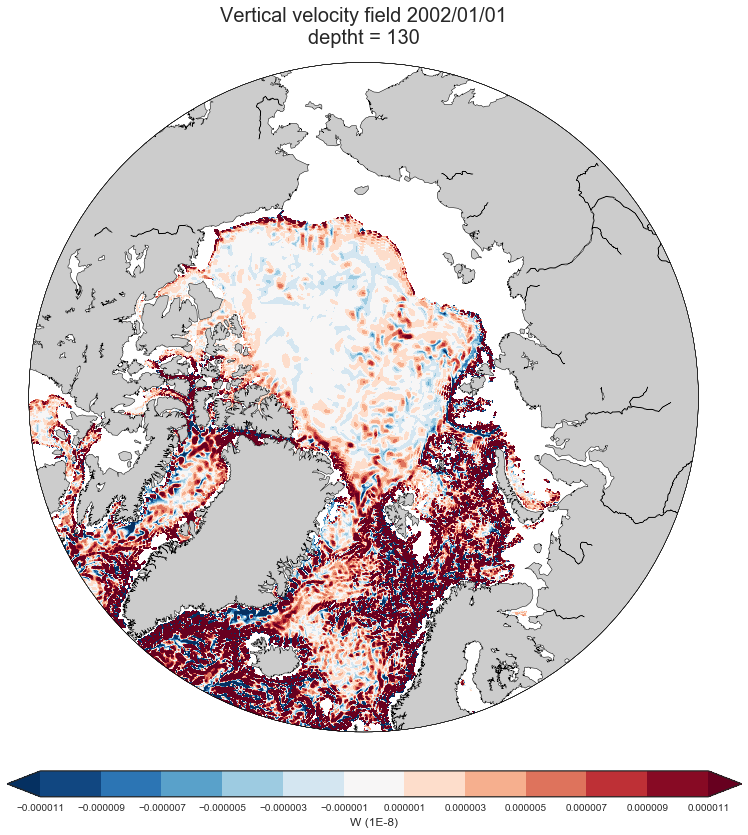

In [264]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
n = 4
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)
CS = proj.contourf(x, y, W[0, :, :], W_lev*1e-6, cmap=plt.cm.RdBu_r, extend='both')
#proj.contour(x, y, W[1, :, :]*1e7, W_lev, linestyles='-', colors='gray', linewidths=1.0)
ax.set_title('Vertical velocity field 2002/01/01\ndeptht = 130', fontsize=20, y=1.02)

cax  = fig.add_axes([0.1, 0.05, 0.85, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('W (1E-8)', fontsize=12)
CBar.ax.tick_params(axis='x', length=0, direction='in')
CBar.set_ticks(W_lev*1e-6)

# Next

* Will calculate the transport of geostrophic flow as "$\mathrm{T\cdot\vec{v_g}}$" for 3 EOF modes.
* Will just estimate the "posibility" of Ekman transport, will not calculate its flux.